# Predicción de Incumplimiento de Prestamos
**Descripción:** predecir el incumplimiento del préstamo a partir de determinadas características del cliente utilizando Machine Learning con python. Este modelo de predicción se puede implementar en un gran conjunto de datos.

**Acerca del conjunto de datos:** Este conjunto de datos trata sobre préstamos pasados. El conjunto de datos incluye detalles de clientes cuyos préstamos ya están cancelados o en mora. Incluye los siguientes campos:  

|Field	|Description|Descripcón|
|-------|-----------|----------|
|Loan_status|	Whether a loan is paid off on in collection| Si el prestamo fue pagado o esta en proceso de cobro|
|Principal|Basic principal loan amount at the|Monto Básico del préstamo|
|Terms|	Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule|Plazos de originación que pueden ser semanales (7 días), quincenales y programas de pago mensuales|
|Effective_date|	When the loan got originated and took effects|Cuándo se originó y entró en vigor el préstamo|
|Due_date|	Since it’s one-time payoff schedule, each loan has one single due date|Dado que se trata de un calendario de liquidación único, cada préstamo tiene una única fecha de vencimiento|
|Age|	Age of applicant|Edad de la solicitante|
|Education|	Education of applicant|Educacion del solicitante|
|Gender|	The gender of applican|Genero|

## 0. Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import metrics
%matplotlib inline

## 1. Read dataset

In [2]:
df = pd.read_csv('loan_train.csv', usecols=['loan_status', 'Principal', 'terms',
                                            'effective_date', 'due_date', 'age', 'education', 'Gender'], 
                 parse_dates=['effective_date','due_date' ])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [5]:
df.shape

(346, 8)

### Data Straucture

In [6]:
df.dtypes.value_counts()

object            3
int64             3
datetime64[ns]    2
dtype: int64

In [7]:
df.dtypes

loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

In [8]:
#check missing values
df.isnull().sum()

loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

## 2. Data Analysis

In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loan_status', ylabel='count'>

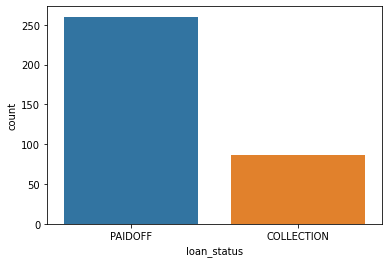

In [10]:
sns.countplot(df['loan_status'], data = df)

In [11]:
round(df['loan_status'].value_counts(normalize = True)*100,2)

PAIDOFF       75.14
COLLECTION    24.86
Name: loan_status, dtype: float64

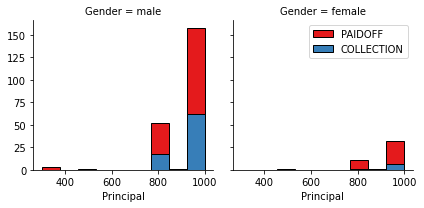

In [12]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g =sns.FacetGrid(col = 'Gender', hue= 'loan_status', data = df, palette="Set1", col_wrap=2)
g.map(plt.hist,'Principal', bins = bins, ec ='k')
g.axes[-1].legend()
plt.show()

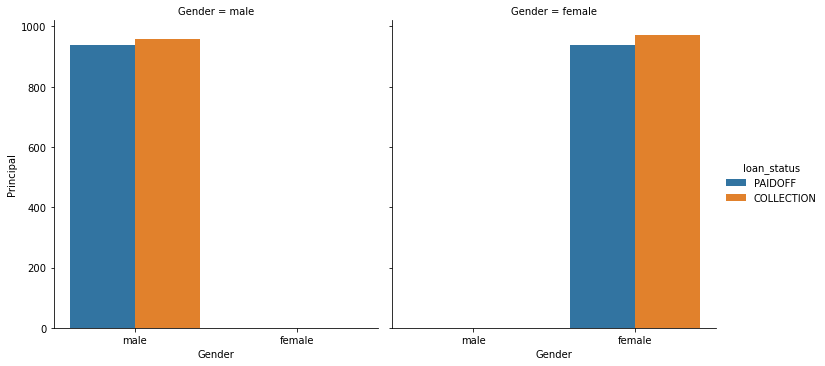

In [13]:
sns.catplot(x= 'Gender', y ='Principal', hue= 'loan_status', data = df, kind ='bar',col = 'Gender',col_wrap=2, ci= None);

In [15]:
df.groupby(['Gender', 'loan_status'])['Principal'].mean()

Gender  loan_status
female  COLLECTION     971.428571
        PAIDOFF        937.777778
male    COLLECTION     956.962025
        PAIDOFF        939.069767
Name: Principal, dtype: float64

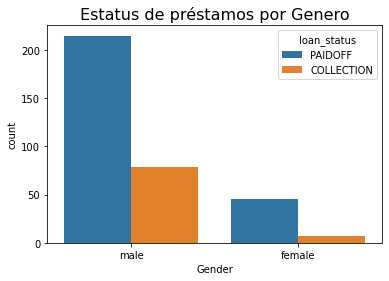

In [18]:
sns.countplot(x ='Gender',hue = 'loan_status', data = df).set_title('Estatus de préstamos por Genero', fontsize=16)
plt.show()

In [19]:
round((df.groupby('Gender')['loan_status'].value_counts(normalize = True)*100),2)

Gender  loan_status
female  PAIDOFF        86.54
        COLLECTION     13.46
male    PAIDOFF        73.13
        COLLECTION     26.87
Name: loan_status, dtype: float64

El 86.54% de las mujeres paga su préstamo mientras que el 73.13% de los hombres

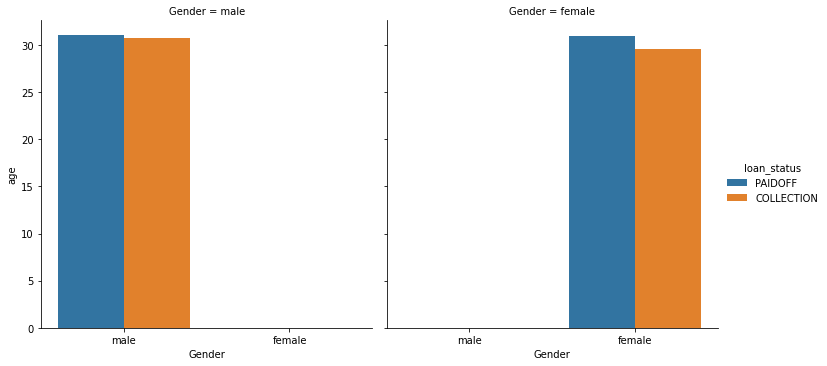

In [20]:
sns.catplot(x= 'Gender', y ='age', hue= 'loan_status', data = df, kind ='bar',col = 'Gender',col_wrap=2, ci= None);

In [21]:
#day off week Create a columns
df['day_of_week'] =df['effective_date'].dt.dayofweek

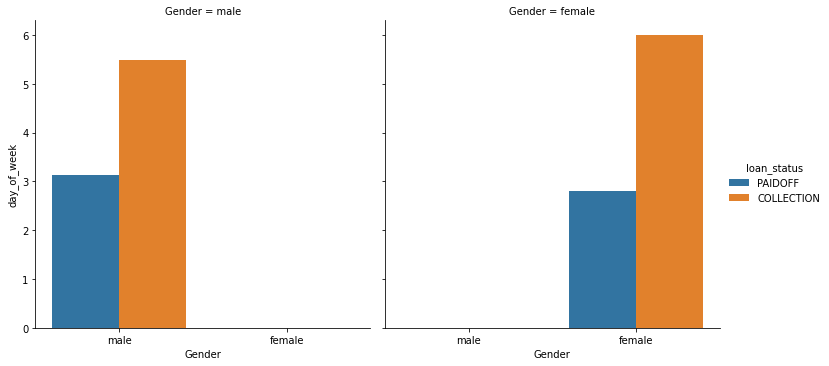

In [22]:
sns.catplot(x= 'Gender', y ='day_of_week', hue= 'loan_status', data = df, kind ='bar',col = 'Gender',col_wrap=2, ci= None);

Vemos que las personas que obtienen el préstamo al final de la semana no lo cancelan, así que usemos la binarización de funciones para establecer valores de umbral inferiores al día 4

In [23]:
# establecer binarizacion para el umbral encontrado
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if(x>3)else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,day_of_week,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [24]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

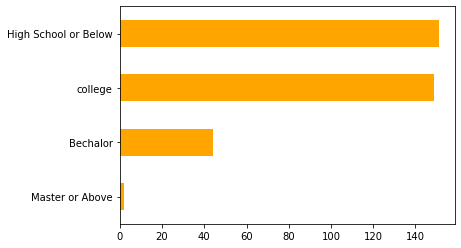

In [30]:
df['education'].value_counts().sort_values().plot(kind='barh', color ='orange');

In [31]:
education = round(df.groupby('education')['loan_status'].value_counts(normalize =True)*100,2)
education

education             loan_status
Bechalor              PAIDOFF        75.00
                      COLLECTION     25.00
High School or Below  PAIDOFF        74.17
                      COLLECTION     25.83
Master or Above       COLLECTION     50.00
                      PAIDOFF        50.00
college               PAIDOFF        76.51
                      COLLECTION     23.49
Name: loan_status, dtype: float64

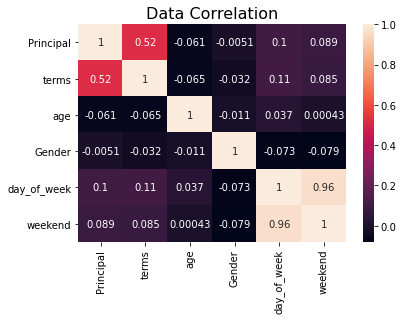

In [53]:
sns.heatmap(df.corr(), annot=True).set_title("Data Correlation", fontsize=16)
plt.show()

## 3. Data Prep

### Convert categorical features to numerical values

In [32]:
# Convert male 0 female 1
df['Gender'] = df["Gender"].replace(['male', 'female'], [0,1])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,day_of_week,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [33]:
df.columns.tolist()

['loan_status',
 'Principal',
 'terms',
 'effective_date',
 'due_date',
 'age',
 'education',
 'Gender',
 'day_of_week',
 'weekend']

### get_dummies

In [34]:
features = df[['Principal', 'terms',  'age','Gender', 'weekend']]
features = pd.concat([features, pd.get_dummies(df['education'])], axis =1)
features.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


### Feature selection (split X nad y target)

In [35]:
X = features
y = df['loan_status']
X.shape, y.shape

((346, 9), (346,))

### Normilize Data
La estandarización de datos da a los datos una media cero y una varianza unitaria (técnicamente debe realizarse después de la división de la prueba del tren)

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
sc = StandardScaler()
X= sc.fit_transform(X)

### Split into train and test

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state =4)

## 4. Building Models

### KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
ks = 10
mean_acc = np.zeros((ks-1))
std_acc = np.zeros((ks-1))
for n in range(1, ks):
    knn = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
    
    std_acc[n-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])
mean_acc

array([0.67142857, 0.58571429, 0.72857143, 0.7       , 0.77142857,
       0.71428571, 0.8       , 0.75714286, 0.74285714])

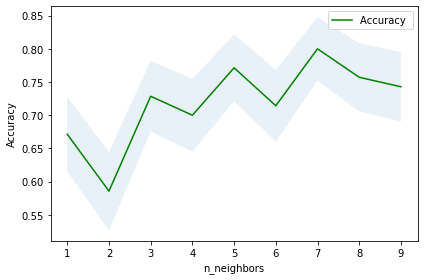

In [42]:
plt.plot(range(1,ks), mean_acc, 'g')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.fill_between(range(1,ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [43]:
print('The best accuracy', mean_acc.max(), 'with n_neighbors=', mean_acc.argmax()+1)

The best accuracy 0.8 with n_neighbors= 7


In [44]:
k=7
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [45]:
y_pred = knn.predict(X_test)

In [46]:
print(metrics.classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

  COLLECTION       0.54      0.47      0.50        15
     PAIDOFF       0.86      0.89      0.88        55

    accuracy                           0.80        70
   macro avg       0.70      0.68      0.69        70
weighted avg       0.79      0.80      0.79        70



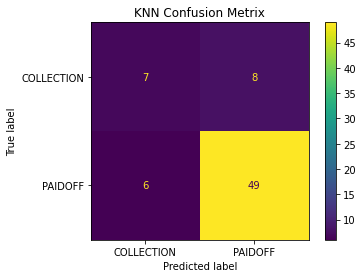

In [47]:
metrics.plot_confusion_matrix(knn,X_test, y_test)
plt.title('KNN Confusion Metrix')
plt.show()

### Decision Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
loantree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
loantree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [50]:
predtree = loantree.predict(X_test)
metrics.accuracy_score(y_test, predtree)

0.6142857142857143

In [51]:
print(metrics.classification_report(y_test, predtree))

              precision    recall  f1-score   support

  COLLECTION       0.27      0.47      0.34        15
     PAIDOFF       0.82      0.65      0.73        55

    accuracy                           0.61        70
   macro avg       0.54      0.56      0.53        70
weighted avg       0.70      0.61      0.64        70



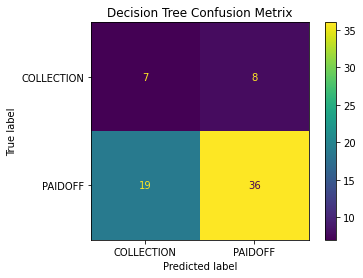

In [37]:
metrics.plot_confusion_matrix(loantree,X_test, y_test)
plt.title('Decision Tree Confusion Metrix')
plt.show()

### Support Vector Machine

In [52]:
from sklearn.svm import SVC

In [53]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [54]:
yhat = svc.predict(X_test)
metrics.accuracy_score(y_test, yhat)

0.7428571428571429

In [55]:
print(metrics.classification_report(y_test, yhat))

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



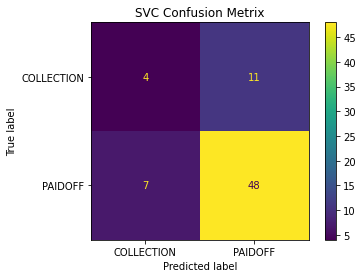

In [42]:
metrics.plot_confusion_matrix(svc,X_test, y_test)
plt.title('SVC Confusion Metrix')
plt.show()

### Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
lr = LogisticRegression(C=0.01, solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [58]:
y_pred = lr.predict(X_test)

In [59]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



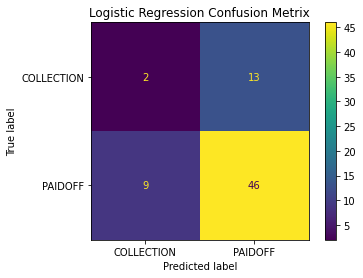

In [47]:
metrics.plot_confusion_matrix(lr,X_test, y_test)
plt.title('Logistic Regression Confusion Metrix')
plt.show()